In [3]:
import numpy as np
import matplotlib.pyplot as plt

class EM:
    p = None
    dim = None # dimension of the data space
    n_points = None # Number of data points
    n_clusters = None # Number of clusters
    pi = None # The prior probability vector of pi_j values
    X = None # the data
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        return
    
    def initialize(self):
        # init p, based on random X but keep all values non zero     
        self.p = np.zeros(shape = (self.dim, self.n_clusters))
        samples = np.random.randint(0, self.n_points-1, self.n_clusters)
        for i, index in enumerate(samples):
            self.p[:, i] = (self.X[index, :] + 1)/(np.sum(self.X[index, :]) + self.dim)        
        
        # the prior
        self.pi = np.ones(shape = self.n_clusters)/self.n_clusters
        return
    
    def fit(self, X):
        self.n_points = X.shape[0]
        self.dim = X.shape[1]
        self.X = X
        self.initialize();
        i = 1
        while i < 100:
            w = self.e_step()
            self.m_step(w)
            i = i + 1
            
        return
    
    def e_step(self):
        W = np.dot(self.X, np.log(self.p)) + np.log(self.pi)
        maxs = W.max(axis=1)
        W = (W.T - maxs).T
        W = (W.T - np.log(np.sum(np.exp(W), axis = 1))).T
        W = np.exp(W)
        return W
    
    def m_step(self, W):
        self.pi = np.sum(W, axis = 0)/self.n_points
        self.p = np.dot(self.X.T, W) + 1.0/self.dim
        
        colsum = np.sum(self.p, axis = 0)
        self.p = self.p/colsum
        return
        

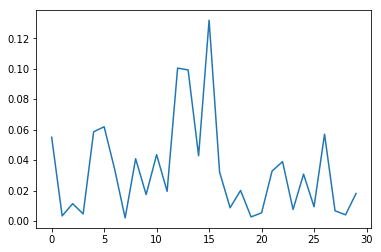

'1: object, model, image, network, cell, visual, unit, input, system, view'

'2: pattern, network, matrix, point, spin, cluster, algorithm, function, phase, probability'

'3: learning, student, error, training, equation, teacher, network, set, weight, parameter'

'4: network, error, committee, set, performance, data, training, neural, method, correlation'

'5: model, data, algorithm, parameter, learning, set, number, distribution, probability, hmm'

'6: network, model, input, data, system, set, neural, learning, function, information'

'7: function, data, model, kernel, set, vector, algorithm, distribution, space, point'

'8: system, speech, network, recognition, neural, hmm, algorithm, janus, approach, learning'

'9: network, neural, system, model, input, signal, output, learning, function, neuron'

'10: neuron, network, model, system, noise, neural, dynamic, synaptic, pattern, function'

'11: model, data, image, images, set, network, system, learning, neural, algorithm'

'12: field, network, mean, distribution, model, learning, approximation, function, weight, data'

'13: network, training, set, error, data, learning, input, function, neural, model'

'14: network, unit, input, output, learning, hidden, weight, pattern, neural, function'

'15: learning, model, network, control, system, controller, input, neural, function, unit'

'16: network, learning, function, algorithm, weight, neural, input, error, problem, vector'

'17: model, network, function, signal, system, algorithm, data, neural, linear, noise'

'18: network, layer, input, output, optical, current, chip, flow, signal, function'

'19: network, data, input, model, function, set, system, training, density, output'

'20: pattern, space, classifier, feature, vector, learning, error, mapping, classification, probability'

'21: network, rules, protein, neural, learning, method, training, knowledge, set, structure'

'22: learning, action, function, algorithm, policy, problem, optimal, states, reinforcement, method'

'23: model, neuron, input, system, learning, motor, network, control, circuit, neural'

'24: neuron, network, layer, input, neural, item, signal, chip, model, weight'

'25: function, learning, network, error, distribution, input, gaussian, result, bound, training'

'26: input, representation, model, hippocampal, learning, pattern, memory, david, michael, region'

'27: cell, neuron, model, input, visual, response, stimulus, spike, firing, information'

'28: algorithm, function, problem, learning, channel, call, cell, cost, number, search'

'29: network, attractor, system, dynamic, neural, model, point, learning, unit, connection'

'30: network, algorithm, neural, input, system, circuit, function, set, chip, learning'

In [4]:
# Load the data
nips_data = np.loadtxt('docword.nips.txt', skiprows=3, dtype=int)
X = np.zeros(shape=(1500, 12419))

# Prepare X
for row in nips_data:
    X[row[0]-1][row[1] -1] = row[2]

em = EM(n_clusters=30)
em.fit(X)

plt.plot(em.pi)
plt.show()

words = [line.strip() for line in open('vocab.nips.txt')]

for j in range(30):
    display("{}: ".format(j+1) + ", ".join(list(np.array(words)[np.argsort(em.p[:,j])[::-1][0:10]])))
    
